In [32]:
%load_ext autoreload
%autoreload 2

import os
import time
import sys

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from distributed_utilities import *
from preprocess_utilities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
stack = 'MD642'

In [34]:
tb_fmt = 'png'

- Upload `sorted_filenames.txt` to S3

In [35]:
transfer_data_synced(os.path.join('CSHL_data', stack), 
                     from_hostname='s3raw', to_hostname='ec2', is_dir=True, include_only='*.'+tb_fmt)

aws s3 cp --recursive s3://mousebrainatlas-rawdata/CSHL_data/MD642 /shared/CSHL_data/MD642 --exclude "*" --include "*.png"


Child returned 0
4.40 seconds.


In [36]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt'), 
                     from_hostname='s3', to_hostname='ec2', is_dir=False)

rm -rf /shared/CSHL_data_processed/MD642/MD642_sorted_filenames.txt && mkdir -p /shared/CSHL_data_processed/MD642
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_sorted_filenames.txt /shared/CSHL_data_processed/MD642/MD642_sorted_filenames.txt


Child returned 0
Child returned 0
0.57 seconds.


# Align

In [37]:
_, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack)
valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]

In [38]:
script = os.path.join(REPO_DIR, 'preprocess', 'align_consecutive_v2.py')
input_dir = os.path.join(RAW_DATA_DIR, stack)
output_dir = os.path.join(DATA_DIR, stack, stack + '_elastix_output')

In [42]:
! rm -r $output_dir

In [43]:
t = time.time()
print 'Align...'

run_distributed("%(script)s %(stack)s %(input_dir)s %(output_dir)s \'%%(kwargs_str)s\' %(fmt)s" % \
                {'script': script,
                'stack': stack,
                'input_dir': input_dir,
                'output_dir': output_dir,
                'fmt': tb_fmt},
                kwargs_list=[{'prev_fn': valid_filenames[i-1], 'curr_fn': valid_filenames[i]} for i in range(1, len(valid_filenames))],
                argument_type='list',
               cluster_size=16,
               jobs_per_node=16) # 

wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # 252 seconds

Align...


16 nodes requested, 16 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.


done in 252.003885984 seconds


qsub returned.


In [44]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_elastix_output'), 
                     from_hostname='ec2', to_hostname='s3', is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD642/MD642_elastix_output s3://mousebrainatlas-data/CSHL_data_processed/MD642/MD642_elastix_output


Child returned 0
20.02 seconds.


# Check final metrics

In [45]:
import re

final_metric = {}
for i in range(1, len(valid_filenames)):
    prev_fn = valid_filenames[i-1]
    curr_fn = valid_filenames[i]
    with open(os.path.join(output_dir, curr_fn + '_to_' + prev_fn, 'elastix.log'), 'r') as f:
        t = f.read()
        g = re.search("Final metric value  = (.*?)\n", t)
#         final_metric[(curr_fn, prev_fn)] = -float(g.groups()[0])
        final_metric[i] = float(g.groups()[0])

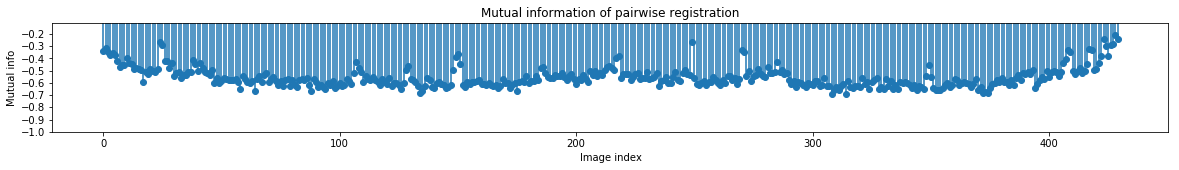

In [46]:
%matplotlib inline
metric_arr = np.array(final_metric.values())
plt.figure(figsize=(20,2));
plt.ylim([-1, metric_arr.max()+.1]);
plt.stem(metric_arr);
plt.title('Mutual information of pairwise registration');
plt.yticks(np.arange(-1, metric_arr.max()+.1, 0.1));
plt.xlabel('Image index');
plt.ylabel('Mutual info');

In [47]:
print 'worst pair:', valid_filenames[np.argmin(final_metric.values())]

worst pair: MD642-N69-2017.01.19-13.59.14_MD642_1_0205


- download `elastix_output/` to local machine, edit consecutive transforms in local GUI, generate `custom_transforms/` to S3, upload to S3.
- determine anchor image, upload `anchor.txt` to S3.

# Compose

In [49]:
# transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_elastix_output'), 
#                      from_hostname='s3', to_hostname='ec2', is_dir=True)

In [25]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_custom_transforms'), 
                     from_hostname='s3', to_hostname='ec2', is_dir=True)

rm -rf /shared/CSHL_data_processed/MD585/MD585_custom_transforms && mkdir -p /shared/CSHL_data_processed/MD585
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_custom_transforms /shared/CSHL_data_processed/MD585/MD585_custom_transforms


Child returned 0
Child returned 0


In [26]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_anchor.txt'), 
                     from_hostname='s3', to_hostname='ec2', is_dir=False)

rm -rf /shared/CSHL_data_processed/MD585/MD585_anchor.txt && mkdir -p /shared/CSHL_data_processed/MD585
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_anchor.txt /shared/CSHL_data_processed/MD585/MD585_anchor.txt


Child returned 0
Child returned 0


In [7]:
anchor_fn = DataManager.load_anchor_filename(stack=stack)

In [28]:
script = os.path.join(REPO_DIR, 'preprocess', 'compose_transform_thumbnail_v2.py')
input_dir = os.path.join(DATA_DIR, stack, stack + '_elastix_output')
output_fn = os.path.join(DATA_DIR, stack, '%(stack)s_transformsTo_%(anchor_fn)s.pkl' % \
                                                dict(stack=stack, anchor_fn=anchor_fn))

In [29]:
! rm -f $output_fn

In [31]:
t = time.time()
print 'Composing transform...'

run_distributed("%(script)s %(stack)s %(input_dir)s \'%%(kwargs_str)s\' %(anchor_idx)d %(output_fn)s" % \
            {'stack': stack,
            'script': script,
            'input_dir': input_dir,
            'anchor_idx': valid_filenames.index(anchor_fn),
            'output_fn': output_fn},
            kwargs_list=[{'filenames': valid_filenames}],
            argument_type='list',
               cluster_size=1,
               exclude_nodes=[33])

linked_name = os.path.join(DATA_DIR, stack, '%(stack)s_transformsTo_anchor.pkl' % dict(stack=stack))
execute_command('rm -f ' + linked_name)
execute_command('ln -s ' + output_fn + ' ' + linked_name)

print 'done in', time.time() - t, 'seconds'

Composing transform...
rm -f /shared/CSHL_data_processed/MD585/MD585_transformsTo_anchor.pkl
ln -s /shared/CSHL_data_processed/MD585/MD585_transformsTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141.pkl /shared/CSHL_data_processed/MD585/MD585_transformsTo_anchor.pkl
done in 10.1688809395 seconds


qsub returned.
Child returned 0
Child returned 0


In [32]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack), 
                     from_hostname='ec2', to_hostname='s3', is_dir=True, include_only='*.pkl')

aws s3 cp --recursive /shared/CSHL_data_processed/MD585 s3://mousebrainatlas-data/CSHL_data_processed/MD585 --exclude "*" --include "*.pkl"


Child returned 0


In [36]:
# transfer_data_synced(os.path.join('CSHL_data_processed', stack), 
#                      from_hostname='ec2', to_hostname='s3', is_dir=True, include_only='*.pkl')

In [84]:
# transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_elastix_output'), 
#                      from_hostname='ec2', to_hostname='s3', is_dir=True)

# Warp

In [ ]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack), 
                     from_hostname='s3', to_hostname='ec2', is_dir=True, include_only='*.pkl')

In [33]:
if stack in all_nissl_stacks:
    pad_bg_color = 'white'
else:
    pad_bg_color = 'auto'

In [44]:
input_dir = os.path.join(RAW_DATA_DIR, stack)
out_dir = os.path.join(DATA_DIR, stack, stack + '_thumbnail_alignedTo_' + anchor_fn)
script = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v2.py')

In [45]:
! rm -rf $out_dir

In [49]:
t = time.time()
print 'Warping...'

transforms_filename = os.path.join(DATA_DIR, stack, '%(stack)s_transformsTo_%(anchor_fn)s.pkl' % \
                                   dict(stack=stack, anchor_fn=anchor_fn))
transforms_to_anchor = pickle.load(open(transforms_filename, 'r'))

if pad_bg_color == 'auto':
    run_distributed('%(script)s %(stack)s %(input_dir)s %(out_dir)s %%(transform)s %%(filename)s %%(output_fn)s thumbnail 0 0 2000 1500 %%(pad_bg_color)s' % \
                    {'script': script,
                    'stack': stack,
                    'input_dir': input_dir,
                    'out_dir': out_dir
                    },
                    kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[fn].flatten())),
                                'filename': fn + '.' + tb_fmt,
                                'output_fn': fn + '_thumbnail_alignedTo_' + anchor_fn + '.tif',
                                'pad_bg_color': 'black' if fn.split('-')[1][0] == 'F' else 'white'}
                                for fn in valid_filenames],
                    exclude_nodes=[33],
                    argument_type='single',
                   cluster_size=16,
                   jobs_per_node=8)
else:
    run_distributed('%(script)s %(stack)s %(input_dir)s %(out_dir)s %%(transform)s %%(filename)s %%(output_fn)s thumbnail 0 0 2000 1500 %(pad_bg_color)s' % \
                    {'script': script,
                    'stack': stack,
                    'input_dir': input_dir,
                    'out_dir': out_dir,
                    'pad_bg_color': pad_bg_color},
                    kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[fn].flatten())),
                                'filename': fn + '.' + tb_fmt,
                                'output_fn': fn + '_thumbnail_alignedTo_' + anchor_fn + '.tif'}
                                for fn in valid_filenames],
                    exclude_nodes=[33],
                    argument_type='single',
                   cluster_size=16,
                   jobs_per_node=8)

print 'done in', time.time() - t, 'seconds'

Warping...
done in 292.164025068 seconds


qsub returned.


In [37]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_thumbnail_alignedTo_' + anchor_fn),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD585/MD585_thumbnail_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141 s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_thumbnail_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141


Child returned 0


- Go to local GUI, download aligned images to check correctness
- Place cropbox.

# Crop

In [10]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_cropbox.txt'), 
                     from_hostname='s3', to_hostname='ec2', is_dir=False)

rm -rf /shared/CSHL_data_processed/MD589/MD589_cropbox.txt && mkdir -p /shared/CSHL_data_processed/MD589
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_cropbox.txt /shared/CSHL_data_processed/MD589/MD589_cropbox.txt


Child returned 0
Child returned 0
0.42 seconds.


In [8]:
xmin, xmax, ymin, ymax, first_sec, last_sec = DataManager.load_cropbox(stack=stack)
w = xmax + 1 - xmin
h = ymax + 1 - ymin
x = xmin
y = ymin

In [9]:
first_fn = sections_to_filenames[first_sec]
last_fn = sections_to_filenames[last_sec]

In [10]:
first_idx_among_valid = valid_filenames.index(first_fn)
last_idx_among_valid = valid_filenames.index(last_fn)

# Crop Thumbnail

In [ ]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_thumbnail_alignedTo_' + anchor_fn),
                    from_hostname='s3',
                    to_hostname='ec2',
                    is_dir=True)

In [55]:
input_dir = os.path.join(DATA_DIR, stack, "%(stack)s_thumbnail_alignedTo_%(anchor_fn)s" % \
                           {'stack': stack, 'anchor_fn': anchor_fn})

output_dir = os.path.join(DATA_DIR, stack, "%(stack)s_thumbnail_alignedTo_%(anchor_fn)s_cropped" % \
                           {'stack': stack, 'anchor_fn': anchor_fn})

execute_command('mkdir -p ' + output_dir)

mkdir -p /shared/CSHL_data_processed/MD585/MD585_thumbnail_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropped


Child returned 0


0

In [56]:
t = time.time()
sys.stderr.write('cropping thumbnail...')

execute_command('mogrify -set filename:name %%t -crop %(w)dx%(h)d+%(x)d+%(y)d -write "%(output_dir)s/%%[filename:name]_cropped.tif" %(input_dir)s/*.tif' % \
    {'input_dir': input_dir,
     'output_dir': output_dir,
    'w':w, 'h':h, 'x':x, 'y':y})

sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 100 seconds

cropping thumbnail...

mogrify -set filename:name %t -crop 512x375+551+116 -write "/shared/CSHL_data_processed/MD585/MD585_thumbnail_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropped/%[filename:name]_cropped.tif" /shared/CSHL_data_processed/MD585/MD585_thumbnail_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141/*.tif


Child returned 0
done in 29.336445 seconds


In [57]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_thumbnail_alignedTo_' + anchor_fn + '_cropped'),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD585/MD585_thumbnail_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropped s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_thumbnail_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropped


Child returned 0


# Expand lossless JP2

In [29]:
transfer_data_synced(os.path.join('CSHL_data', stack),
                    from_hostname='s3raw',
                    to_hostname='ec2',
                    is_dir=True,
                    include_only='*_lossless.jp2')

aws s3 cp --recursive s3://mousebrainatlas-rawdata/CSHL_data/MD589 /shared/CSHL_data/MD589 --exclude "*" --include "*_lossless.jp2"


Child returned 0


In [ ]:
t = time.time()
sys.stderr.write('expanding...')

output_dir = create_if_not_exists(os.path.join(DATA_DIR, stack, stack + '_lossless_tif'))
input_dir = os.path.join(RAW_DATA_DIR, stack)

# filenames_to_expand = [fn for fn in filenames[first_idx:last_idx+1] if not os.path.exists(os.path.join(input_dir, fn + '_lossless.tif'))]

filenames_to_expand = [fn for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1] 
                       if not os.path.exists(os.path.join(input_dir, fn + '_lossless.tif'))]

run_distributed('export LD_LIBRARY_PATH=/home/ubuntu/KDU79_Demo_Apps_for_Linux-x86-64_170108:$LD_LIBRARY_PATH; %(kdu_bin)s -i %(input_dir)s/%%(fn)s_lossless.jp2 -o %(output_dir)s/%%(fn)s_lossless.tif' % \
                {'kdu_bin': KDU_EXPAND_BIN,
                 'output_dir': output_dir,
                'input_dir': input_dir},
                kwargs_list={'fn': filenames_to_expand},
                exclude_nodes=[33],
                argument_type='single',
               cluster_size=16)

sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 900 seconds.

In [ ]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_tif'),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD657/MD657_lossless_tif s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_lossless_tif


# Warping and cropping lossless

In [24]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_tif'),
                    from_hostname='s3',
                    to_hostname='ec2',
                    is_dir=True)
# 3000 seconds

rm -rf /shared/CSHL_data_processed/MD585/MD585_lossless_tif && mkdir -p /shared/CSHL_data_processed/MD585
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_lossless_tif /shared/CSHL_data_processed/MD585/MD585_lossless_tif


Child returned 0


3079.07781506


Child returned 0
3079.08 seconds.


In [26]:
tf_filepath = os.path.join(DATA_DIR, stack, '%(stack)s_transformsTo_anchor.pkl' % {'stack':stack})
tfs = pickle.load(open(tf_filepath, 'r'))
# Note that the index from trasform pickle file starts at 0, BUT the .._renamed folder index starts at 1.#

lossless_tif_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_tif')
lossless_aligned_cropped_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped')

script_fp = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v2.py')

In [53]:
rm -r $lossless_aligned_cropped_dir

In [58]:
if stack in all_nissl_stacks:
    pad_bg_color = 'white'
else:
    pad_bg_color = 'auto'

In [101]:
rm -r $lossless_aligned_cropped_dir/*

In [102]:
t = time.time()
sys.stderr.write('warping and cropping lossless...')

wait_num_nodes(16)
                   
if pad_bg_color == 'auto':
    # If alternating, then black padding for F sections, white padding for N sections.
    run_distributed(command='%(script_path)s %(stack)s %(lossless_tif_dir)s %(lossless_aligned_cropped_dir)s %%(transform)s %%(filename)s %%(output_fn)s lossless %(x)d %(y)d %(w)d %(h)d %%(pad_bg_color)s'%\
                    {'script_path': script_fp,
                    'stack': stack,
                    'lossless_tif_dir': lossless_tif_dir,
                    'lossless_aligned_cropped_dir': lossless_aligned_cropped_dir,
                    'x': x,
                    'y': y,
                    'w': w,
                    'h': h},
                    kwargs_list=[{'transform': ','.join(map(str, tfs[fn].flatten())),
                                'filename': fn + '_lossless.tif',
                                'output_fn': fn + '_lossless_alignedTo_' + anchor_fn + '_cropped.tif',
                                'pad_bg_color': 'black' if fn.split('-')[1][0] == 'F' else 'white'}
                                for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]],
#                                  for fn in valid_filenames[first_idx_among_valid:first_idx_among_valid+16]],
                    exclude_nodes=[33],
                    argument_type='single',
                   cluster_size=16,
                   jobs_per_node=4)
else:
    run_distributed(command='%(script_path)s %(stack)s %(lossless_tif_dir)s %(lossless_aligned_cropped_dir)s %%(transform)s %%(filename)s %%(output_fn)s lossless %(x)d %(y)d %(w)d %(h)d %(pad_bg_color)s'%\
                    {'script_path': script_fp,
                    'stack': stack,
                    'lossless_tif_dir': lossless_tif_dir,
                    'lossless_aligned_cropped_dir': lossless_aligned_cropped_dir,
                    'x': x,
                    'y': y,
                    'w': w,
                    'h': h,
                    'pad_bg_color': pad_bg_color},
                    kwargs_list=[{'transform': ','.join(map(str, tfs[fn].flatten())),
                                'filename': fn + '_lossless.tif',
                                'output_fn': fn + '_lossless_alignedTo_' + anchor_fn + '_cropped.tif'}
                                for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]],
#                                  for fn in valid_filenames[first_idx_among_valid:first_idx_among_valid+16]],
                    exclude_nodes=[33],
                    argument_type='single',
                   cluster_size=16,
                   jobs_per_node=4)

wait_qsub_complete()
    
sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 4140 seconds (AWS)

warping and cropping lossless...Wait for SGE to know all nodes (timeout in 300 seconds)...
All nodes are ready.
16 nodes requested, 16 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 4140.555290 seconds


In [103]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped'),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True) 
# 512 seconds

aws s3 cp --recursive /shared/CSHL_data_processed/MD585/MD585_lossless_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropped s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_lossless_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropped


Child returned 0
512.95 seconds.


# (optional) contrast stretch Neurotrace images

In [141]:
script_fp = os.path.join(REPO_DIR, 'preprocess', 'stretch_contrast_neurotrace.py')
# in_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_tif')
# out_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_tif_contrast_stretched')
in_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped')
out_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched')

In [142]:
! mkdir -p $out_dir

In [145]:
t = time.time()
sys.stderr.write('Contrast stretch neurotrace images...')
               
run_distributed(command='%(script_path)s %%(in_fn)s %%(out_fn)s %(imin)d %(imax)d'%\
                    {'script_path': script_fp,
                     'imin': 0,
                     'imax': 400
                    },
                    kwargs_list=[{'in_fn': os.path.join(in_dir, fn + '_lossless_alignedTo_' + anchor_fn + '_cropped.tif'),
                                'out_fn': os.path.join(out_dir, fn + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched.tif')}
                                for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]
                                if fn.split('-')[1][0] == 'F'],
                    exclude_nodes=[33],
                    argument_type='single',
                   cluster_size=16)

sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 2500 seconds

Contrast stretch neurotrace images...

Setting autoscaling group cfncluster-yuncongCluster-ComputeFleet-P6LX3QPGCISG capaticy to 16.
Wait for SGE to know all nodes...
All nodes are ready.


qsub returned.
done in 2443.298327 seconds


In [9]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched'),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_contrast_stretched s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_contrast_stretched


Child returned 0


# Generate JPEG

In [18]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped'),
                    from_hostname='s3',
                    to_hostname='ec2',
                    is_dir=True)

rm -rf /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped && mkdir -p /shared/CSHL_data_processed/MD589
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped


Child returned 0
Child returned 0


In [111]:
script_fp = os.path.join(REPO_DIR, 'preprocess', 'generate_other_versions_v2.py')
input_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped')
output_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_compressed')

In [131]:
! rm -r $output_dir/*

In [132]:
t = time.time()
print 'Generating compressed image...',

if stack in all_nissl_stacks:
    
    run_distributed('%(script)s %(stack)s %(input_dir)s \'%%(input_filenames)s\' --output_compressed_dir %(output_compressed_dir)s' % \
                dict(script=script_fp,
                     stack=stack,
                     input_dir=input_dir,
                     output_compressed_dir=output_dir),
                    kwargs_list={'input_filenames': 
                                 [fn + '_lossless_alignedTo_' + anchor_fn + '_cropped.tif' 
                                  for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]]},
                    exclude_nodes=[33],
                    argument_type='list2',
                    cluster_size=16,
                   jobs_per_node=16)
    
else:
    run_distributed('%(script)s %(stack)s %(input_dir)s \'%%(input_filenames)s\' --output_compressed_dir %(output_compressed_dir)s' % \
                    dict(script=script_fp,
                         stack=stack,
                         input_dir=input_dir,
                         output_compressed_dir=output_dir),
                        kwargs_list={'input_filenames': 
                                     [fn + '_lossless_alignedTo_' + anchor_fn + '_cropped.tif' 
                                      for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1] 
                                      if fn.split('-')[1].startswith('N')]},
                        exclude_nodes=[33],
                        argument_type='list2',
                         cluster_size=16,
                       jobs_per_node=16)

wait_qsub_complete()
    
print 'done in', time.time() - t, 'seconds' # 765 seconds.

Generating compressed image...

16 nodes requested, 16 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.


 done in 520.338327169 seconds


qsub returned.


In [133]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_compressed'),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD585/MD585_lossless_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropped_compressed s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_lossless_alignedTo_MD585-N47-2015.07.16-22.50.52_MD585_3_0141_cropped_compressed


Child returned 0
53.57 seconds.


# Generate JPEG for neurotrace

In [146]:
script_fp = os.path.join(REPO_DIR, 'preprocess', 'generate_other_versions_v2.py')
input_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched')
out_jpeg_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_compressed')

In [147]:
t = time.time()
print 'Generating compressed image...',

run_distributed('%(script)s %(stack)s %(input_dir)s \'%%(input_filenames)s\' --output_compressed_dir %(output_compressed_dir)s' % \
                dict(script=script_fp,
                     stack=stack,
                     input_dir=input_dir,
                     output_compressed_dir=out_jpeg_dir),
                    kwargs_list={'input_filenames': 
                                 [fn + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched.tif' 
                                  for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1] 
                                  if fn.split('-')[1].startswith('F')]},
                    exclude_nodes=[33],
                    argument_type='list2',
                    cluster_size=16)
                
print 'done in', time.time() - t, 'seconds'

Generating compressed image... Setting autoscaling group cfncluster-yuncongCluster-ComputeFleet-P6LX3QPGCISG capaticy to 16.
Wait for SGE to know all nodes...
All nodes are ready.
done in 1520.75712705 seconds


qsub returned.


In [148]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_compressed'),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True,
                    include_only='*contrast_stretched*.jpg')

aws s3 cp --recursive /shared/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_compressed s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_compressed --exclude "*" --include "*contrast_stretched*.jpg"


Child returned 0


In [ ]:
# t = time.time()
# print 'Generating saturation image...',

# run_distributed4('%(script)s %(stack)s %(input_dir)s \'%%(input_filenames)s\' --output_saturation_dir %(output_saturation_dir)s' % \
#                 dict(script=script_fp,
#                      stack=stack,
#                      input_dir=input_dir,
#                      output_saturation_dir=out_sat_dir,
#                      kwargs_list={'input_filenames': [fn + '_lossless_alignedTo_' + anchor_fn + '_cropped.tif' for fn in filenames[first_idx:last_idx+1]]},
#                     exclude_nodes=exclude_nodes,
#                     argument_type='list2')

# print 'done in', time.time() - t, 'seconds'

# Generate Masks

In [11]:
script = os.path.join(REPO_DIR, 'preprocess', 'generate_thumbnail_masks_v4.py')
input_dir = os.path.join(RAW_DATA_DIR, stack)
output_dir = create_if_not_exists(os.path.join(DATA_DIR, stack, stack + '_submasks'))
! rm -f output_dir/*

In [16]:
t = time.time()
print 'Generating thumbnail mask...',

wait_num_nodes(16)

run_distributed(command='%(script_path)s %(stack)s %(input_dir)s \'%%(filenames)s\' %(output_dir)s --border_dissim_percentile %(border_dissim_percentile)d --min_size %(min_size)d' % \
                {'script_path': script,
                'stack': stack,
                'input_dir': input_dir,
                'output_dir': output_dir,
                'border_dissim_percentile': DEFAULT_BORDER_DISSIMILARITY_PERCENTILE,
                'min_size': DEFAULT_MINSIZE},
                kwargs_list=dict(filenames=valid_filenames),
                exclude_nodes=[33],
                argument_type='list2',
               cluster_size=16,
               jobs_per_node=1)

wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # 300s (aws)

Generating thumbnail mask... Setting autoscaling group cfncluster-yuncongCluster-ComputeFleet-1LFRACYHLTNL8 capaticy to 16...it may take more than 5 minutes for SGE to know new hosts.


Wait for SGE to know all nodes (timeout in 300 seconds)...
All nodes are ready.
16 nodes requested, 16 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.


done in 403.646880865 seconds


qsub returned.


In [18]:
transfer_data_synced(relative_to_ec2(output_dir),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD594/MD594_submasks s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_submasks


Child returned 0
3.72 seconds.


- download `submasks/` to local machine
- review them in GUI
- generate `submasks_modified/`, `masks/`, `submasks_finalDecisions.txt`, upload to S3

# Warp Thumbnail Masks

In [21]:
script = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v2.py')
input_dir = os.path.join(DATA_DIR, stack, stack + '_masks')

In [22]:
transfer_data_synced(relative_to_ec2(input_dir),
                    from_hostname='s3',
                    to_hostname='ec2',
                    is_dir=True)

rm -rf /shared/CSHL_data_processed/MD594/MD594_masks && mkdir -p /shared/CSHL_data_processed/MD594
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_masks /shared/CSHL_data_processed/MD594/MD594_masks


Child returned 0
Child returned 0
1.87 seconds.


In [23]:
output_dir = os.path.join(DATA_DIR, stack, stack + '_masks_alignedTo_' + anchor_fn)

execute_command('rm -rf ' + output_dir)

transforms_to_anchor = load_pickle(DataManager.get_transforms_filename(stack=stack))

rm -rf /shared/CSHL_data_processed/MD594/MD594_masks_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172


Child returned 0


In [24]:
t = time.time()
print 'warping thumbnail mask...',

run_distributed('%(script)s %(stack)s %(input_dir)s %(output_dir)s %%(transform)s %%(filename)s %%(output_fn)s thumbnail 0 0 2000 1500 black' % \
                {'script': script,
                'stack': stack,
                'input_dir': input_dir,
                'output_dir': output_dir},
                kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[fn].flatten())),
                            'filename': fn + '_mask.png',
                            'output_fn': fn + '_mask_alignedTo_' + anchor_fn + '.png'}
                            for fn in valid_filenames],
                exclude_nodes=[33],
                argument_type='single',
               cluster_size=16,
               jobs_per_node=16)

wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # 20 seconds (aws)

warping thumbnail mask... Setting autoscaling group cfncluster-yuncongCluster-ComputeFleet-1LFRACYHLTNL8 capaticy to 16...it may take more than 5 minutes for SGE to know new hosts.


16 nodes requested, 1 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.


done in 76.2961359024 seconds


qsub returned.


In [27]:
transfer_data_synced(relative_to_ec2(output_dir),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD594/MD594_masks_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_masks_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172


Child returned 0
3.42 seconds.


# Crop Thumbnail Masks

In [28]:
input_dir = os.path.join(DATA_DIR, stack, stack + '_masks_alignedTo_' + anchor_fn)
output_dir = os.path.join(DATA_DIR, stack, stack + '_masks_alignedTo_' + anchor_fn + '_cropped')

execute_command('rm -rf ' + output_dir)
execute_command('mkdir -p ' + output_dir)

rm -rf /shared/CSHL_data_processed/MD594/MD594_masks_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped
mkdir -p /shared/CSHL_data_processed/MD594/MD594_masks_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
Child returned 0


0

In [29]:
t = time.time()
sys.stderr.write('cropping thumbnail mask...')

execute_command('mogrify -set filename:name %%t -crop %(w)dx%(h)d+%(x)d+%(y)d -write "%(output_dir)s/%%[filename:name]_cropped.png" %(input_dir)s/*.png' % \
    {'stack': stack,
    'input_dir': input_dir,
    'output_dir': output_dir,
    'w':xmax+1-xmin, 'h':ymax+1-ymin, 'x':xmin, 'y':ymin})

sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 70s (aws)

cropping thumbnail mask...

mogrify -set filename:name %t -crop 538x347+618+89 -write "/shared/CSHL_data_processed/MD594/MD594_masks_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/%[filename:name]_cropped.png" /shared/CSHL_data_processed/MD594/MD594_masks_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172/*.png


Child returned 0
done in 70.435083 seconds


In [31]:
transfer_data_synced(relative_to_ec2(output_dir),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD594/MD594_masks_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_masks_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
2.15 seconds.
